# Testing Unidata/Siphon for solar power forecasting applications

This notebook is meant to test the usefulness of [Unidata's Siphon project](https://github.com/Unidata/siphon) for solar forecasting applications. Siphon has the potential to make accessing subsets of model data lot easier than using the traditional NOMADS services.

Sections:
1. [GFS](#GFS) and [GFS 0.25 deg](#GFS-0.25-deg)
2. [NAM](#NAM)
2. [RAP](#RAP)
2. HRRR [NCEP](#NCEP) and [ESRL](#ESRL)
2. [NDFD](#NDFD)

Requirements:
* All siphon requirements as described [here](http://siphon.readthedocs.org/en/latest/developerguide.html).
* Matplotlib, Seaborn, IPython notebook.

Authors: 
* Will Holmgren, University of Arizona, July 2015

Standard scientific python imports

In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()

import pandas as pd
import numpy as np

import datetime

Imports for weather data.

In [2]:
import netCDF4
from netCDF4 import num2date

from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

Define start and end of forecast period.

In [3]:
start = datetime.datetime(2015,7,29,12) #utc
end = start + datetime.timedelta(days=7)

## GFS

To get started, I'll try to follow Siphon's [timeseries example docs](http://siphon.readthedocs.org/en/latest/examples/generated/NCSS_Timeseries_Examples.html) fairly closely.

In [4]:
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p5deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p5deg/Best')
best_gfs.datasets

{'Best GFS Half Degree Forecast Time Series': <siphon.catalog.Dataset at 0x7f247f428ac8>}

In [5]:
best_ds = list(best_gfs.datasets.values())[0]
best_ds.access_urls

{'CdmRemote': 'http://thredds.ucar.edu/thredds/cdmremote/grib/NCEP/GFS/Global_0p5deg/Best',
 'ISO': 'http://thredds.ucar.edu/thredds/iso/grib/NCEP/GFS/Global_0p5deg/Best',
 'NCML': 'http://thredds.ucar.edu/thredds/ncml/grib/NCEP/GFS/Global_0p5deg/Best',
 'NetcdfSubset': 'http://thredds.ucar.edu/thredds/ncss/grib/NCEP/GFS/Global_0p5deg/Best',
 'OPENDAP': 'http://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p5deg/Best',
 'UDDC': 'http://thredds.ucar.edu/thredds/uddc/grib/NCEP/GFS/Global_0p5deg/Best',
 'WCS': 'http://thredds.ucar.edu/thredds/wcs/grib/NCEP/GFS/Global_0p5deg/Best',
 'WMS': 'http://thredds.ucar.edu/thredds/wms/grib/NCEP/GFS/Global_0p5deg/Best'}

In [6]:
ncss = NCSS(best_ds.access_urls['NetcdfSubset'])

In [7]:
ncss.variables

{'5-Wave_Geopotential_Height_isobaric',
 'Absolute_vorticity_isobaric',
 'Albedo_surface_Mixed_intervals_Average',
 'Apparent_temperature_height_above_ground',
 'Best_4_layer_Lifted_Index_surface',
 'Categorical_Freezing_Rain_surface_Mixed_intervals_Average',
 'Categorical_Ice_Pellets_surface_Mixed_intervals_Average',
 'Categorical_Rain_surface_Mixed_intervals_Average',
 'Categorical_Snow_surface_Mixed_intervals_Average',
 'Cloud_Work_Function_entire_atmosphere_single_layer_Mixed_intervals_Average',
 'Cloud_mixing_ratio_isobaric',
 'Cloud_water_entire_atmosphere_single_layer',
 'Convective_Precipitation_Rate_surface_Mixed_intervals_Average',
 'Convective_available_potential_energy_pressure_difference_layer',
 'Convective_available_potential_energy_surface',
 'Convective_inhibition_pressure_difference_layer',
 'Convective_inhibition_surface',
 'Convective_precipitation_surface_Mixed_intervals_Accumulation',
 'Dewpoint_temperature_height_above_ground',
 'Downward_Long-Wave_Radp_Flux_surf

In [8]:
query = ncss.query()
query.lonlat_point(-110.9, 32.2).vertical_level(100000).time_range(start, end)
query.variables('Temperature_isobaric').accept('netcdf')

var=Temperature_isobaric&time_start=2015-07-29T12%3A00%3A00&time_end=2015-08-05T12%3A00%3A00&latitude=32.2&longitude=-110.9&vertCoord=100000&accept=netcdf

In [9]:
data = ncss.get_data(query)

In [10]:
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format UNDEFINED):
    Conventions: CF-1.6
    history: Written by CFPointWriter
    title: Extract Points data from Grid file /data/ldm/pub/native/grid/NCEP/GFS/Global_0p5deg/GFS-Global_0p5deg.ncx3
    time_coverage_start: 2015-07-29T12:00:00Z
    time_coverage_end: 2015-08-05T12:00:00Z
    geospatial_lat_min: 32.1995
    geospatial_lat_max: 32.2005
    geospatial_lon_min: -110.9005
    geospatial_lon_max: -110.8995
    featureType: timeSeriesProfile
    dimensions(sizes): profile(57), station(1), isobaric3(1), station_name_strlen(10), station_description_strlen(33)
    variables(dimensions): float32 isobaric3(station,profile,isobaric3), float32 Temperature_isobaric(station,profile,isobaric3), |S1 station_name(station,station_name_strlen), |S1 station_description(station,station_description_strlen), float64 latitude(station), float64 longitude(station), float64 time(station,profile)
    groups: 

In [11]:
temp = data.variables['Temperature_isobaric']
time = data.variables['time']

In [12]:
time

<class 'netCDF4._netCDF4.Variable'>
float64 time(station, profile)
    units: Hour since 2015-07-16T00:00:00Z
    calendar: proleptic_gregorian
    standard_name: time
    long_name: GRIB forecast or observation time
unlimited dimensions: 
current shape = (1, 57)
filling off

In [13]:
time_vals = num2date(time[:].squeeze(), time.units)
time_vals[::5]

array([datetime.datetime(2015, 7, 29, 12, 0),
       datetime.datetime(2015, 7, 30, 3, 0),
       datetime.datetime(2015, 7, 30, 18, 0),
       datetime.datetime(2015, 7, 31, 9, 0),
       datetime.datetime(2015, 8, 1, 0, 0),
       datetime.datetime(2015, 8, 1, 15, 0),
       datetime.datetime(2015, 8, 2, 6, 0),
       datetime.datetime(2015, 8, 2, 21, 0),
       datetime.datetime(2015, 8, 3, 12, 0),
       datetime.datetime(2015, 8, 4, 3, 0),
       datetime.datetime(2015, 8, 4, 18, 0),
       datetime.datetime(2015, 8, 5, 9, 0)], dtype=object)

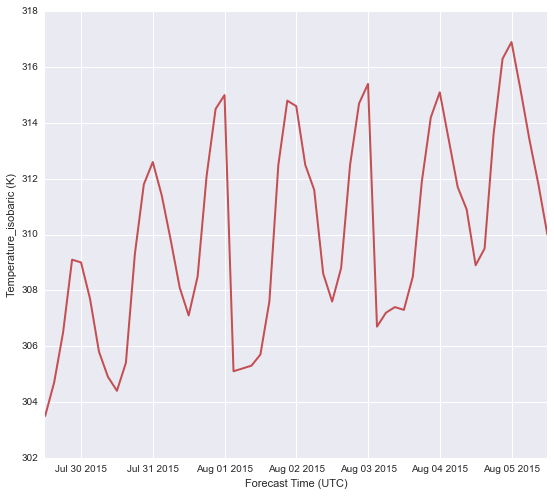

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(9, 8))
ax.plot(time_vals, temp[:].squeeze(), 'r', linewidth=2)
ax.set_ylabel(temp.standard_name + ' (%s)' % temp.units)
ax.set_xlabel('Forecast Time (UTC)')

In [15]:
cloud_vars = ['Total_cloud_cover_boundary_layer_cloud_Mixed_intervals_Average',
                'Total_cloud_cover_convective_cloud',
                'Total_cloud_cover_entire_atmosphere_Mixed_intervals_Average',
                'Total_cloud_cover_high_cloud_Mixed_intervals_Average',
                'Total_cloud_cover_low_cloud_Mixed_intervals_Average',
                'Total_cloud_cover_middle_cloud_Mixed_intervals_Average']

query = ncss.query()
query.lonlat_point(-110.9, 32.2).time_range(start, end)
query.variables(*cloud_vars)
query.accept('netcdf')

data = ncss.get_data(query)
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format UNDEFINED):
    Conventions: CF-1.6
    history: Written by CFPointWriter
    title: Extract Points data from Grid file /data/ldm/pub/native/grid/NCEP/GFS/Global_0p5deg/GFS-Global_0p5deg.ncx3
    time_coverage_start: 2015-07-29T12:00:00Z
    time_coverage_end: 2015-08-05T12:00:00Z
    geospatial_lat_min: 32.1995
    geospatial_lat_max: 32.2005
    geospatial_lon_min: -110.9005
    geospatial_lon_max: -110.8995
    featureType: timeSeries
    dimensions(sizes): obs(57), station(1), station_id_strlen(9), station_description_strlen(33)
    variables(dimensions): float64 latitude(station), float64 longitude(station), |S1 station_id(station,station_id_strlen), |S1 station_description(station,station_description_strlen), float64 time(obs), int32 stationIndex(obs), float32 Total_cloud_cover_entire_atmosphere_Mixed_intervals_Average(obs), float32 Total_cloud_cover_boundary_layer_cloud_Mixed_intervals_Average

In [16]:
total_cloud_cover = data.variables['Total_cloud_cover_entire_atmosphere_Mixed_intervals_Average']

In [17]:
time = data.variables['time']
time_vals = num2date(time[:].squeeze(), time.units)

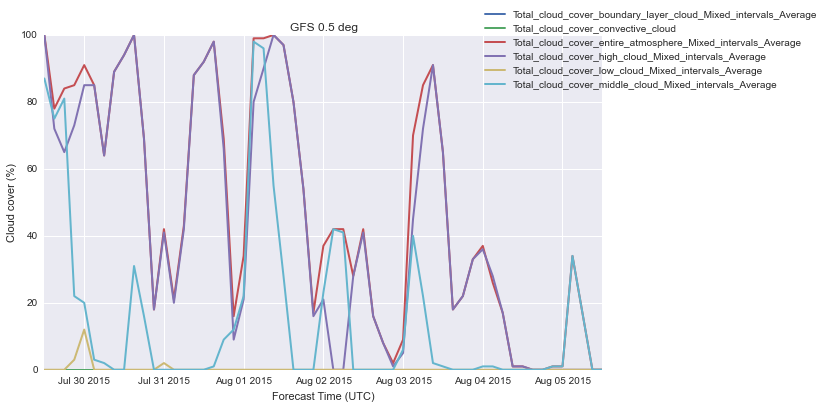

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for varname in cloud_vars:
    ax.plot(time_vals, data[varname][:].squeeze(), linewidth=2, label=varname)
    
ax.set_ylabel('Cloud cover' + ' (%s)' % total_cloud_cover.units)
ax.set_xlabel('Forecast Time (UTC)')
ax.legend(bbox_to_anchor=(1.4,1.1))
ax.set_title('GFS 0.5 deg')

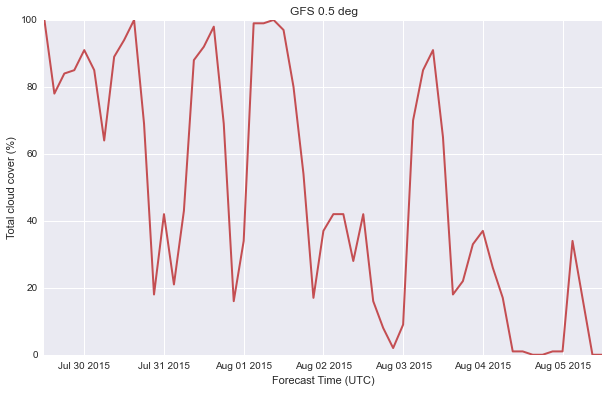

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(time_vals, total_cloud_cover[:].squeeze(), 'r', linewidth=2)
ax.set_ylabel('Total cloud cover' + ' (%s)' % total_cloud_cover.units)
ax.set_xlabel('Forecast Time (UTC)')
ax.set_title('GFS 0.5 deg')

In [20]:
total_cloud_cover_05_deg = total_cloud_cover

## GFS 0.25 deg

Now with the new, higher resolution GFS...

In [21]:
best_gfs_nc_sub = NCSS('http://thredds-jumbo.unidata.ucar.edu/thredds/ncss/grib/NCEP/GFS/Global_0p25deg/Best')

In [22]:
best_gfs_nc_sub.variables

{'5-Wave_Geopotential_Height_isobaric',
 'Absolute_vorticity_isobaric',
 'Albedo_surface_Mixed_intervals_Average',
 'Apparent_temperature_height_above_ground',
 'Best_4_layer_Lifted_Index_surface',
 'Categorical_Freezing_Rain_surface_Mixed_intervals_Average',
 'Categorical_Ice_Pellets_surface_Mixed_intervals_Average',
 'Categorical_Rain_surface_Mixed_intervals_Average',
 'Categorical_Snow_surface_Mixed_intervals_Average',
 'Cloud_Work_Function_entire_atmosphere_single_layer_Mixed_intervals_Average',
 'Cloud_mixing_ratio_isobaric',
 'Cloud_water_entire_atmosphere_single_layer',
 'Convective_Precipitation_Rate_surface_Mixed_intervals_Average',
 'Convective_available_potential_energy_pressure_difference_layer',
 'Convective_available_potential_energy_surface',
 'Convective_inhibition_pressure_difference_layer',
 'Convective_inhibition_surface',
 'Convective_precipitation_surface_Mixed_intervals_Accumulation',
 'Dewpoint_temperature_height_above_ground',
 'Downward_Long-Wave_Radp_Flux_surf

In [23]:
variables = [
             'Downward_Short-Wave_Radiation_Flux_surface_Mixed_intervals_Average',
             'Temperature_surface',
             'Total_cloud_cover_boundary_layer_cloud_Mixed_intervals_Average',
             'Total_cloud_cover_convective_cloud',
             'Total_cloud_cover_entire_atmosphere_Mixed_intervals_Average',
             'Total_cloud_cover_high_cloud_Mixed_intervals_Average',
             'Total_cloud_cover_low_cloud_Mixed_intervals_Average',
             'Total_cloud_cover_middle_cloud_Mixed_intervals_Average',
             ]

query = best_gfs_nc_sub.query()
query.lonlat_point(-110.9, 32.2).time_range(start, end)
query.variables(*variables)
#query.vertical_level(100000)
#query.add_query_parameter(height_above_ground=1)
query.accept('netcdf')

data = best_gfs_nc_sub.get_data(query)
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format UNDEFINED):
    Conventions: CF-1.6
    history: Written by CFPointWriter
    title: Extract Points data from Grid file /data/ldm/pub/native/grid/NCEP/GFS/Global_0p25deg/GFS-Global_0p25deg.ncx3
    time_coverage_start: 2015-07-29T12:00:00Z
    time_coverage_end: 2015-08-05T12:00:00Z
    geospatial_lat_min: 32.1995
    geospatial_lat_max: 32.2005
    geospatial_lon_min: -110.9005
    geospatial_lon_max: -110.8995
    featureType: timeSeries
    dimensions(sizes): obs(57), station(1), station_id_strlen(9), station_description_strlen(33)
    variables(dimensions): float64 latitude(station), float64 longitude(station), |S1 station_id(station,station_id_strlen), |S1 station_description(station,station_description_strlen), float64 time(obs), int32 stationIndex(obs), float32 Total_cloud_cover_entire_atmosphere_Mixed_intervals_Average(obs), float32 Downward_Short-Wave_Radiation_Flux_surface_Mixed_intervals_A

In [24]:
time = data.variables['time']
time_vals = num2date(time[:].squeeze(), time.units)

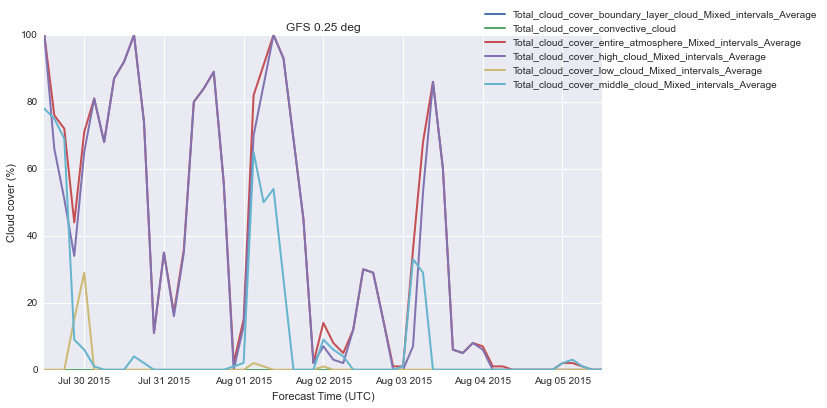

In [25]:
cloud_vars = variables[2:]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for varname in cloud_vars:
    ax.plot(time_vals, data[varname][:].squeeze(), linewidth=2, label=varname)
    
ax.set_ylabel('Cloud cover' + ' (%s)' % total_cloud_cover.units)
ax.set_xlabel('Forecast Time (UTC)')
ax.legend(bbox_to_anchor=(1.4,1.1))
ax.set_title('GFS 0.25 deg')

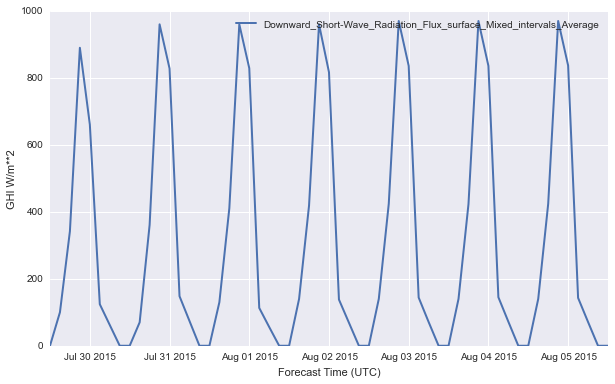

In [26]:
ghis = variables[:1]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for varname in ghis:
    ax.plot(time_vals, data[varname][:].squeeze(), linewidth=2, label=varname)
ax.set_ylabel('GHI W/m**2')
ax.set_xlabel('Forecast Time (UTC)')
ax.legend()

I don't know anything about the GHI forecasts from the GFS, but I don't think they'll be very good for solar power forecasting.

Compare the 0.5 and 0.25 deg forecasts...

In [27]:
total_cloud_cover_025_deg = data.variables['Total_cloud_cover_entire_atmosphere_Mixed_intervals_Average']

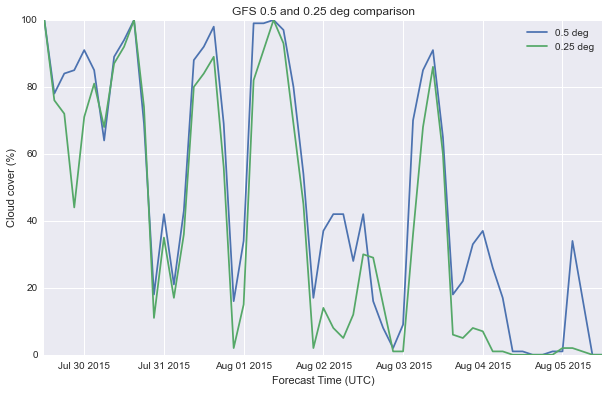

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(time_vals, total_cloud_cover_05_deg, label='0.5 deg')
ax.plot(time_vals, total_cloud_cover_025_deg, label='0.25 deg')
ax.legend()
ax.set_ylabel('Cloud cover (%)')
ax.set_xlabel('Forecast Time (UTC)')
ax.set_title('GFS 0.5 and 0.25 deg comparison')

## NAM

UCAR thredds has 12 km NAM from both the NOAAPORT and CONDUIT services.

In [29]:
best_nam_nc_sub = NCSS('http://thredds.ucar.edu/thredds/ncss/grib/NCEP/NAM/CONUS_12km/conduit/Best')

In [30]:
best_nam_nc_sub.variables

{'Absolute_vorticity_isobaric',
 'Albedo_surface',
 'Baseflow-Groundwater_Runoff_surface_Mixed_intervals_Accumulation',
 'Best_4_layer_Lifted_Index_pressure_difference_layer',
 'Blackadars_Mixing_Length_Scale_hybrid',
 'Brightness_temperature_atmosphere_top',
 'Canopy_Conductance_surface',
 'Categorical_Freezing_Rain_surface',
 'Categorical_Ice_Pellets_surface',
 'Categorical_Rain_surface',
 'Categorical_Snow_surface',
 'Composite_reflectivity_entire_atmosphere_single_layer',
 'Convective_Cloud_Efficiency_entire_atmosphere_single_layer',
 'Convective_Precipitation_Rate_surface',
 'Convective_available_potential_energy_pressure_difference_layer',
 'Convective_available_potential_energy_surface',
 'Convective_cloud_cover_entire_atmosphere_single_layer',
 'Convective_inhibition_pressure_difference_layer',
 'Convective_inhibition_surface',
 'Convective_precipitation_surface_3_Hour_Accumulation',
 'Deep_Convective_Heating_Rate_entire_atmosphere_single_layer_Mixed_intervals_Average',
 'Dewpo

The NAM has cloud cover and GHI data. I'm guessing that GHI is not very good.

In [31]:
variables = ['Downward_Short-Wave_Radiation_Flux_surface',
             'Downward_Short-Wave_Radiation_Flux_surface_Mixed_intervals_Average',
             'Temperature_surface',
             'High_cloud_cover_high_cloud',
             'Low_cloud_cover_low_cloud',
             'Medium_cloud_cover_middle_cloud',
             'Total_cloud_cover_entire_atmosphere_single_layer',
             ]

query = best_nam_nc_sub.query()
query.lonlat_point(-110.9, 32.2).time_range(start, end)
query.variables(*variables)
#query.vertical_level(100000)
#query.add_query_parameter(height_above_ground=1)
query.accept('netcdf')

data = best_nam_nc_sub.get_data(query)
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format UNDEFINED):
    Conventions: CF-1.6
    history: Written by CFPointWriter
    title: Extract Points data from Grid file /data/ldm/pub/native/grid/NCEP/NAM/CONUS_12km_conduit/NAM-CONUS_12km-conduit.ncx3
    time_coverage_start: 2015-07-29T12:00:00Z
    time_coverage_end: 2015-08-02T06:00:00Z
    geospatial_lat_min: 32.1995
    geospatial_lat_max: 32.2005
    geospatial_lon_min: -110.9005
    geospatial_lon_max: -110.8995
    featureType: timeSeries
    dimensions(sizes): obs(31), station(1), station_id_strlen(9), station_description_strlen(33)
    variables(dimensions): float64 latitude(station), float64 longitude(station), |S1 station_id(station,station_id_strlen), |S1 station_description(station,station_description_strlen), float64 time(obs), int32 stationIndex(obs), float32 Medium_cloud_cover_middle_cloud(obs), float32 Downward_Short-Wave_Radiation_Flux_surface_Mixed_intervals_Average(obs), float32

In [32]:
time = data.variables['time']
time_vals = num2date(time[:].squeeze(), time.units)

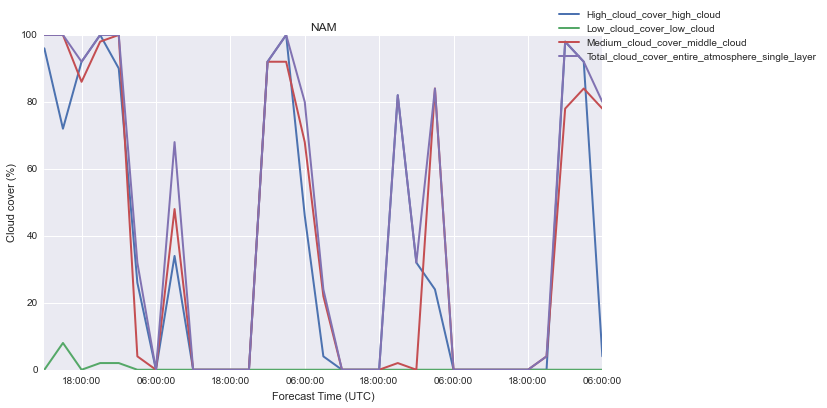

In [33]:
cloud_vars = variables[3:]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for varname in cloud_vars:
    ax.plot(time_vals, data[varname][:].squeeze(), linewidth=2, label=varname)
    
ax.set_ylabel('Cloud cover' + ' (%s)' % total_cloud_cover.units)
ax.set_xlabel('Forecast Time (UTC)')
ax.legend(bbox_to_anchor=(1.4,1.1))
ax.set_title('NAM')

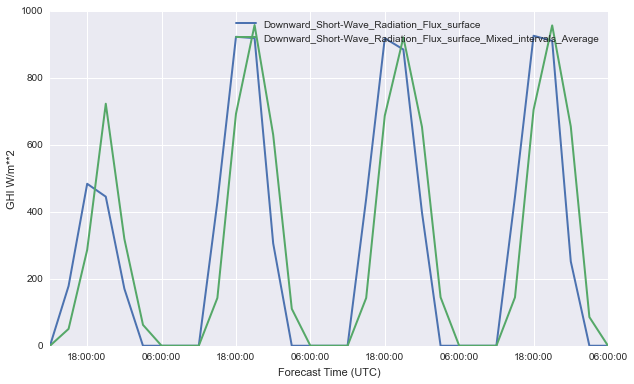

In [34]:
ghis = variables[:2]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for varname in ghis:
    ax.plot(time_vals, data[varname][:].squeeze(), linewidth=2, label=varname)
ax.set_ylabel('GHI W/m**2')
ax.set_xlabel('Forecast Time (UTC)')
ax.legend()

## RAP

The UCAR THREDDS server does not appear to pull cloud cover or irradiance data from the 13 km NCEP RAP, so we will use the 20 km data.

In [35]:
best_rr_nc_sub = NCSS('http://thredds.ucar.edu/thredds/ncss/grib/NCEP/RAP/CONUS_20km/Best')

In [36]:
best_rr_nc_sub.variables

{'Absolute_vorticity_isobaric',
 'Baseflow-Groundwater_Runoff_surface_1_Hour_Accumulation',
 'Best_4_layer_Lifted_Index_pressure_difference_layer',
 'Categorical_Freezing_Rain_surface',
 'Categorical_Ice_Pellets_surface',
 'Categorical_Rain_surface',
 'Categorical_Snow_surface',
 'Composite_reflectivity_entire_atmosphere_single_layer',
 'Convective_available_potential_energy_pressure_difference_layer',
 'Convective_available_potential_energy_surface',
 'Convective_inhibition_pressure_difference_layer',
 'Convective_inhibition_surface',
 'Convective_precipitation_surface_1_Hour_Accumulation',
 'Dewpoint_depression_or_deficit_height_above_ground',
 'Dewpoint_temperature_height_above_ground',
 'Echo_Top_entire_atmosphere_single_layer',
 'Geopotential_height_cloud_base',
 'Geopotential_height_cloud_tops',
 'Geopotential_height_convective_cloud_top',
 'Geopotential_height_equilibrium',
 'Geopotential_height_highest_tropospheric_freezing',
 'Geopotential_height_isobaric',
 'Geopotential_heig

There is low, mid, high, and total cloud cover data.

In [37]:
variables = ['Total_cloud_cover_entire_atmosphere_single_layer',
             'Low_cloud_cover_low_cloud',
             'Medium_cloud_cover_middle_cloud',
             'High_cloud_cover_high_cloud',
             'Temperature_surface']

query = best_rr_nc_sub.query()
query.lonlat_point(-110.9, 32.2).time_range(start, end)
query.variables(*variables)
#query.vertical_level(100000)
#query.add_query_parameter(height_above_ground=1)
query.accept('netcdf')

data = best_rr_nc_sub.get_data(query)
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format UNDEFINED):
    Conventions: CF-1.6
    history: Written by CFPointWriter
    title: Extract Points data from Grid file /data/ldm/pub/native/grid/NCEP/RR/CONUS_20km/RAP-CONUS_20km.ncx3
    time_coverage_start: 2015-07-29T12:00:00Z
    time_coverage_end: 2015-07-30T15:00:00Z
    geospatial_lat_min: 32.1995
    geospatial_lat_max: 32.2005
    geospatial_lon_min: -110.9005
    geospatial_lon_max: -110.8995
    featureType: timeSeries
    dimensions(sizes): obs(28), station(1), station_id_strlen(9), station_description_strlen(33)
    variables(dimensions): float64 latitude(station), float64 longitude(station), |S1 station_id(station,station_id_strlen), |S1 station_description(station,station_description_strlen), float64 time(obs), int32 stationIndex(obs), float32 Medium_cloud_cover_middle_cloud(obs), float32 Low_cloud_cover_low_cloud(obs), float32 Temperature_surface(obs), float32 Total_cloud_cover_entir

In [38]:
time = data.variables['time']
time_vals = num2date(time[:].squeeze(), time.units)

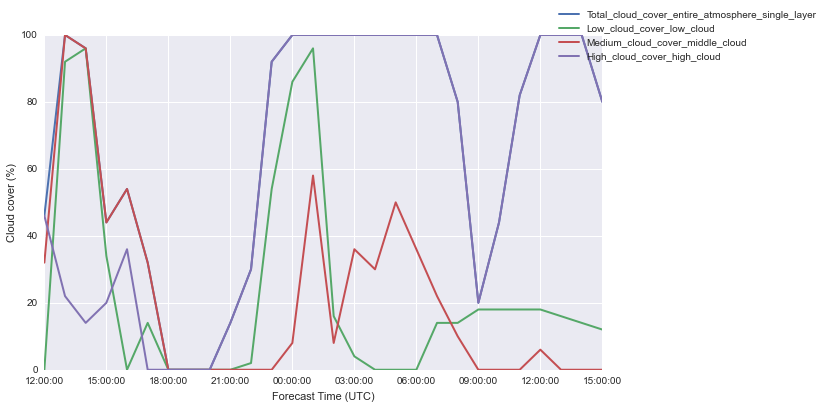

In [39]:
cloud_vars = variables[:-1]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for varname in cloud_vars:
    ax.plot(time_vals, data[varname][:].squeeze(), linewidth=2, label=varname)
    
ax.set_ylabel('Cloud cover' + ' (%s)' % total_cloud_cover.units)
ax.set_xlabel('Forecast Time (UTC)')
ax.legend(bbox_to_anchor=(1.4,1.1))

## HRRR

There are two different UCAR HRRR datasets: NOAA/GSD and NCEP.

### NCEP

In [40]:
best_hrrr_nc_sub = NCSS('http://thredds-jumbo.unidata.ucar.edu/thredds/ncss/grib/NCEP/HRRR/CONUS_2p5km/Best')

In [41]:
best_hrrr_nc_sub.variables

{'Best_4-layer_lifted_index_pressure_difference_layer',
 'Categorical_freezing_rain_surface',
 'Categorical_ice_pellets_surface',
 'Categorical_rain_surface',
 'Categorical_snow_surface',
 'Composite_reflectivity_entire_atmosphere',
 'Convective_available_potential_energy_pressure_difference_layer',
 'Convective_available_potential_energy_surface',
 'Convective_inhibition_pressure_difference_layer',
 'Convective_inhibition_surface',
 'Dewpoint_temperature_height_above_ground',
 'Dewpoint_temperature_isobaric',
 'Echo_top_cloud_tops',
 'Geopotential_height_adiabatic_condensation_lifted',
 'Geopotential_height_cloud_ceiling',
 'Geopotential_height_cloud_tops',
 'Geopotential_height_isobaric',
 'Geopotential_height_surface',
 'High_cloud_cover_high_cloud',
 'Hourly_Maximum_of_Downward_Vertical_Velocity_in_the_lowest_400hPa_pressure_difference_layer_1_Hour_Maximum',
 'Hourly_Maximum_of_Simulated_Reflectivity_at_1_km_AGL_height_above_ground_1_Hour_Maximum',
 'Hourly_Maximum_of_Updraft_Helic

Like the RAP, there is low, mid, high, and total cloud cover. NCEP HRRR 2014-2015 does have GHI in the original grib files, but it's not very good (see Holmgren et al AMS 2015).

In [42]:
variables = ['Total_cloud_cover_entire_atmosphere',
             'Low_cloud_cover_low_cloud',
             'Medium_cloud_cover_middle_cloud',
             'High_cloud_cover_high_cloud',]

query = best_hrrr_nc_sub.query()
query.lonlat_point(-110.9, 32.2).time_range(start, end)
query.variables(*variables)
#query.vertical_level(100000)
#query.add_query_parameter(height_above_ground=1)
query.accept('netcdf')

data = best_hrrr_nc_sub.get_data(query)
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format UNDEFINED):
    Conventions: CF-1.6
    history: Written by CFPointWriter
    title: Extract Points data from Grid file /data/ldm/pub/native/grid/NCEP/HRRR/CONUS_2p5km/NCEP_HRRR_CONUS_2p5km.ncx3
    time_coverage_start: 2015-07-29T12:00:00Z
    time_coverage_end: 2015-07-30T12:00:00Z
    geospatial_lat_min: 32.1995
    geospatial_lat_max: 32.2005
    geospatial_lon_min: -110.9005
    geospatial_lon_max: -110.8995
    featureType: timeSeries
    dimensions(sizes): obs(25), station(1), station_id_strlen(9), station_description_strlen(33)
    variables(dimensions): float64 latitude(station), float64 longitude(station), |S1 station_id(station,station_id_strlen), |S1 station_description(station,station_description_strlen), float64 time(obs), int32 stationIndex(obs), float32 High_cloud_cover_high_cloud(obs), float32 Low_cloud_cover_low_cloud(obs), float32 Total_cloud_cover_entire_atmosphere(obs), float32 M

In [43]:
time = data.variables['time']
time_vals = num2date(time[:].squeeze(), time.units)

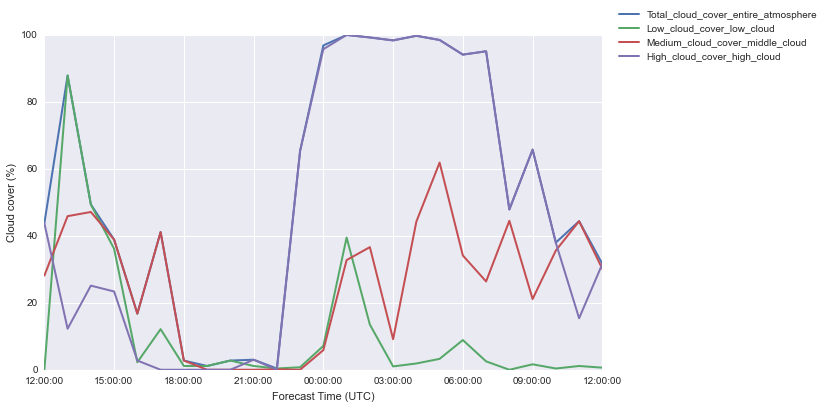

In [44]:
cloud_vars = variables

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for varname in cloud_vars:
    ax.plot(time_vals, data[varname][:].squeeze(), linewidth=2, label=varname)
    
ax.set_ylabel('Cloud cover' + ' (%s)' % total_cloud_cover.units)
ax.set_xlabel('Forecast Time (UTC)')
ax.legend(bbox_to_anchor=(1.4,1.1))

### NOAA

NOAA lists a bunch of different HRRR runs at 

http://rapidrefresh.noaa.gov/HRRR/

The HRRRX run at NOAA has a much improved irradiance forecast, but I'm not sure if that's what the Unidata thredds server pulls in.

Unidata's "Best" link is for an archive instead of the most recent forecasts. So, we'll just look at one forecast.

In [45]:
best_hrrr_nc_sub = NCSS('http://thredds-jumbo.unidata.ucar.edu/thredds/ncss/grib/HRRR/CONUS_3km/surface/HRRR_CONUS_3km_surface_201507291400.grib2')

In [46]:
variables = ['Total_cloud_cover_entire_atmosphere',
             'Low_cloud_cover_UnknownLevelType-214',
             'Medium_cloud_cover_UnknownLevelType-224',
             'High_cloud_cover_UnknownLevelType-234',
             'Temperature_surface',
             'Downward_short-wave_radiation_flux_surface']

query = best_hrrr_nc_sub.query()
query.lonlat_point(-110.9, 32.2).time_range(start, end)
query.variables(*variables)
query.accept('netcdf')

data = best_hrrr_nc_sub.get_data(query)
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format UNDEFINED):
    Conventions: CF-1.6
    history: Written by CFPointWriter
    title: Extract Points data from Grid file /data/ldm/pub/native/grid/NOAA_GSD/HRRR/CONUS_3km/surface/HRRR_CONUS_3km_surface_201507291400.grib2.ncx3#LambertConformal_1059X1799-38p51N-97p48W
    time_coverage_start: 2015-07-29T14:00:00Z
    time_coverage_end: 2015-07-30T05:00:00Z
    geospatial_lat_min: 32.1995
    geospatial_lat_max: 32.2005
    geospatial_lon_min: -110.9005
    geospatial_lon_max: -110.8995
    featureType: timeSeries
    dimensions(sizes): obs(80), station(1), station_id_strlen(9), station_description_strlen(33)
    variables(dimensions): float64 latitude(station), float64 longitude(station), |S1 station_id(station,station_id_strlen), |S1 station_description(station,station_description_strlen), float64 time(obs), int32 stationIndex(obs), float32 Low_cloud_cover_UnknownLevelType-214(obs), float32 Temperature

ESRL HRRR has low, mid, high, and total cloud cover variables. 

It also has a GHI field.

In [47]:
time = data.variables['time']
time_vals = num2date(time[:].squeeze(), time.units) # this isn't working right for the hrrr

In [48]:
ghi = data['Downward_short-wave_radiation_flux_surface']

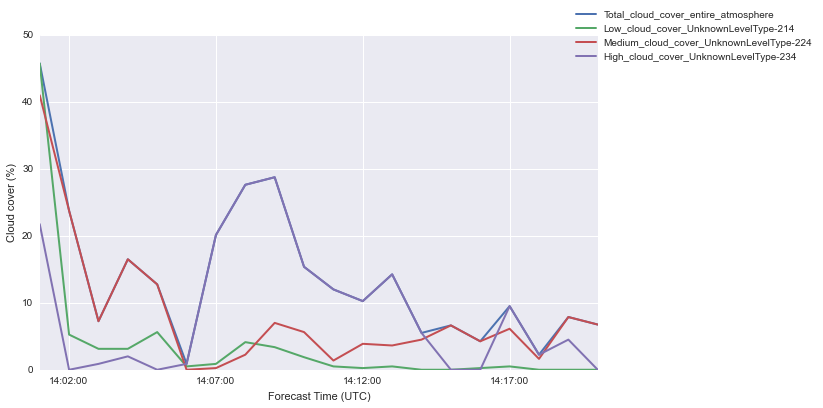

In [49]:
cloud_vars = variables[:4]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for varname in cloud_vars:
    ax.plot(time_vals, data[varname][:].squeeze(), linewidth=2, label=varname)
    
ax.set_ylabel('Cloud cover' + ' (%s)' % total_cloud_cover.units)
ax.set_xlabel('Forecast Time (UTC)')
ax.legend(bbox_to_anchor=(1.4,1.1))

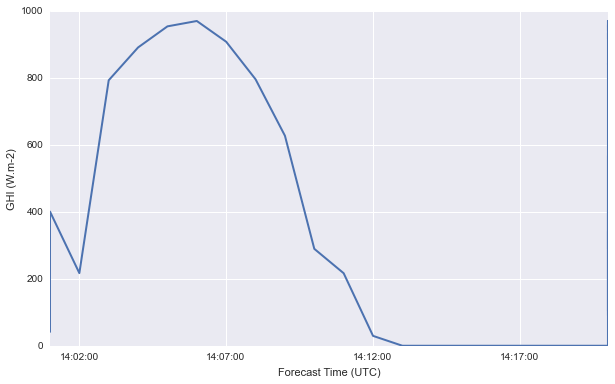

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(time_vals, ghi[:].squeeze(), linewidth=2)
ax.set_ylabel('GHI' + ' (%s)' % ghi.units)
ax.set_xlabel('Forecast Time (UTC)')

The times are messed up, but I'm sure they can be fixed with a little effort.

## NDFD

In [51]:
best_ndfd_nc_sub = NCSS('http://thredds.ucar.edu/thredds/ncss/grib/NCEP/NDFD/NWS/CONUS/CONDUIT/Best')

In [52]:
ndfd_vars = ['Total_cloud_cover_surface',
             'Temperature_surface',
             'Wind_speed_surface']

query = best_ndfd_nc_sub.query()
query.lonlat_point(-110.9, 32.2).time_range(start, end)
query.variables(*ndfd_vars)
#query.vertical_level(100000)
#query.add_query_parameter(height_above_ground=1)
query.accept('netcdf')

data = best_ndfd_nc_sub.get_data(query)
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format UNDEFINED):
    Conventions: CF-1.6
    history: Written by CFPointWriter
    title: Extract Points data from Grid file /data/ldm/pub/native/grid/NCEP/NDFD/NWS/NDFD_NWS_CONUS_CONDUIT.ncx3
    time_coverage_start: 2015-07-29T12:00:00Z
    time_coverage_end: 2015-08-05T12:00:00Z
    geospatial_lat_min: 32.1995
    geospatial_lat_max: 32.2005
    geospatial_lon_min: -110.9005
    geospatial_lon_max: -110.8995
    featureType: timeSeries
    dimensions(sizes): obs(74), station(1), station_id_strlen(9), station_description_strlen(33)
    variables(dimensions): float64 latitude(station), float64 longitude(station), |S1 station_id(station,station_id_strlen), |S1 station_description(station,station_description_strlen), float64 time(obs), int32 stationIndex(obs), float32 Temperature_surface(obs), float32 Wind_speed_surface(obs), float32 Total_cloud_cover_surface(obs)
    groups: 

In [53]:
time = data.variables['time']
time_vals = num2date(time[:].squeeze(), time.units)

In [54]:
total_cloud_cover = data.variables['Total_cloud_cover_surface']
temp = data.variables['Temperature_surface']
wind = data.variables['Wind_speed_surface']

(0, 100)

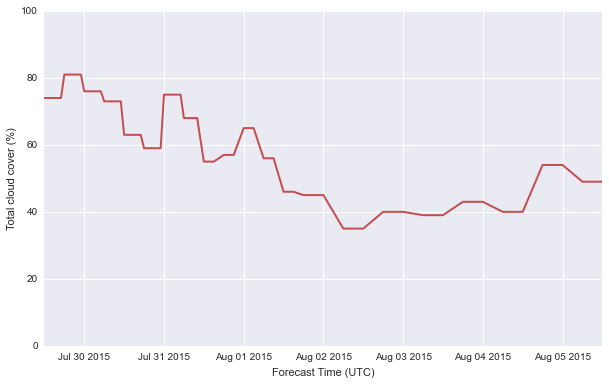

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(time_vals, total_cloud_cover[:].squeeze(), 'r', linewidth=2)
ax.set_ylabel('Total cloud cover' + ' (%s)' % total_cloud_cover.units)
ax.set_xlabel('Forecast Time (UTC)')
plt.ylim(0,100)

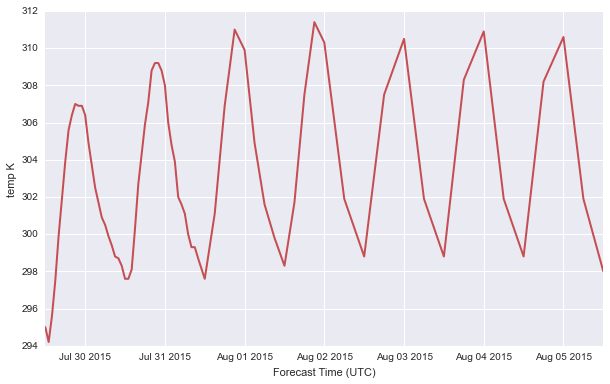

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(time_vals, temp[:].squeeze(), 'r', linewidth=2)
ax.set_ylabel('temp {}'.format(temp.units))
ax.set_xlabel('Forecast Time (UTC)')

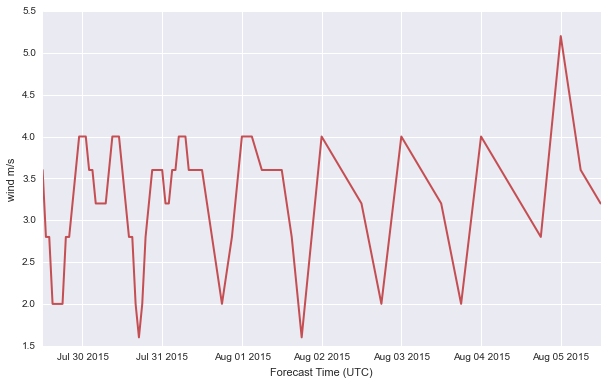

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(time_vals, wind[:].squeeze(), 'r', linewidth=2)
ax.set_ylabel('wind {}'.format(wind.units))
ax.set_xlabel('Forecast Time (UTC)')